In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import itertools
from datetime import datetime, date

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as PathEffects
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
from scipy.ndimage import gaussian_filter 
from IPython.display import Image, display
from PIL import Image
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap, add_hasia_labels
from wrf_funcs import calc_gridpoints_domain, calc_i_j_parent_start, calc_number_nodes_pes

In [2]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

In [3]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/HASIA_ch2_analysis/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/HASIA_ch2_analysis/figs/'      # figures


### Import elevation data

In [4]:
fname = path_to_data + 'elevation_data/ETOPO1_Bed_g_gmt4.grd'
version = 'bedrock'
grid = xr.open_dataset(fname, engine='netcdf4')
# Add more metadata and fix some names
names = {"ice": "Ice Surface", "bedrock": "Bedrock"}
grid = grid.rename(z=version, x="lon", y="lat")
grid[version].attrs["long_name"] = "{} relief".format(names[version])
grid[version].attrs["units"] = "meters"
grid[version].attrs["vertical_datum"] = "sea level"
grid[version].attrs["datum"] = "WGS84"
grid.attrs["title"] = "ETOPO1 {} Relief".format(names[version])
grid.attrs["doi"] = "10.7289/V5C8276M"

In [5]:
# regrid topo to ERA5 horizontal resolution
newlats = np.arange(-90, 90.5, 0.5)
newlons = np.arange(-180., 180.5, 0.5)

regrid_topo = grid.interp(lon=newlons, lat=newlats)

In [6]:
## update the name of the case from the dict file
case_name='feb2010_expand'

# import configuration file for case dictionary choice
yaml_doc = '../data/wrf_casestudy.yml'
config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
case_dict = config[case_name]

In [7]:
# dates 
start_date = case_dict['start_date']
end_date = case_dict['end_date']
timestep = case_dict['timestep']
domains = case_dict['domains']
resolutions = case_dict['resolutions']

In [8]:
parent_grid_ratio = [1, int((resolutions[0]/resolutions[1]))]
print(parent_grid_ratio)

e_we, e_sn, ref_lat, ref_lon = calc_gridpoints_domain(domains, resolutions, parent_grid_ratio)
print(e_we, e_sn, ref_lat, ref_lon)

i_prt, j_prt = calc_i_j_parent_start(domains, resolutions)
print(i_prt, j_prt)

max_nodes = calc_number_nodes_pes(int(e_we[0]), int(e_sn[0]))
print('Max nodes is', max_nodes)

[1, 3]
[927, 1927] [494, 928] 35.0 77.5
[1, 222] [1, 62]
Max nodes is 51


### Make figure

In [9]:
# Load sliced variables.
etopo = grid.sel(lat=slice(domains[0][2], domains[0][3]), lon=slice(domains[0][0], domains[0][1]))
lats = etopo.lat
lons = etopo.lon
topo = etopo.bedrock

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
j = 10
dx = np.arange(domains[0][0],domains[0][1]+j,j)
dy = np.arange(domains[0][2],domains[0][3]+j,j)

# domain extent info 
# [xmin, ymin]
sr_xy = []
sr_width = []
sr_height = []
dom_lbl = []
lbl_loc = []

for i, (d, res) in enumerate(zip(domains, resolutions)):
    sr_xy.append([d[0], d[2]])
    sr_width.append((d[1] - d[0]))
    sr_height.append((d[3]- d[2]))
    dom_lbl.append('D0{0} ({1} km) [{2}x{3}]'.format(i+1, res, round(e_we[i]), round(e_sn[i])))
    lbl_loc.append([d[0]+1, d[2]+1])
    
print(sr_xy)
print(sr_width)
print(sr_height)
print(dom_lbl)

# make a colormap that has land and ocean clearly delineated and of the
# same length (256 + 256)
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = mcolors.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)

# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = mcolors.TwoSlopeNorm(vmin=-250., vcenter=1, vmax=4000)

[[40, 15], [58, 20]]
[75, 52]
[40, 25]
['D01 (9 km) [927x494]', 'D02 (3 km) [1927x928]']


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


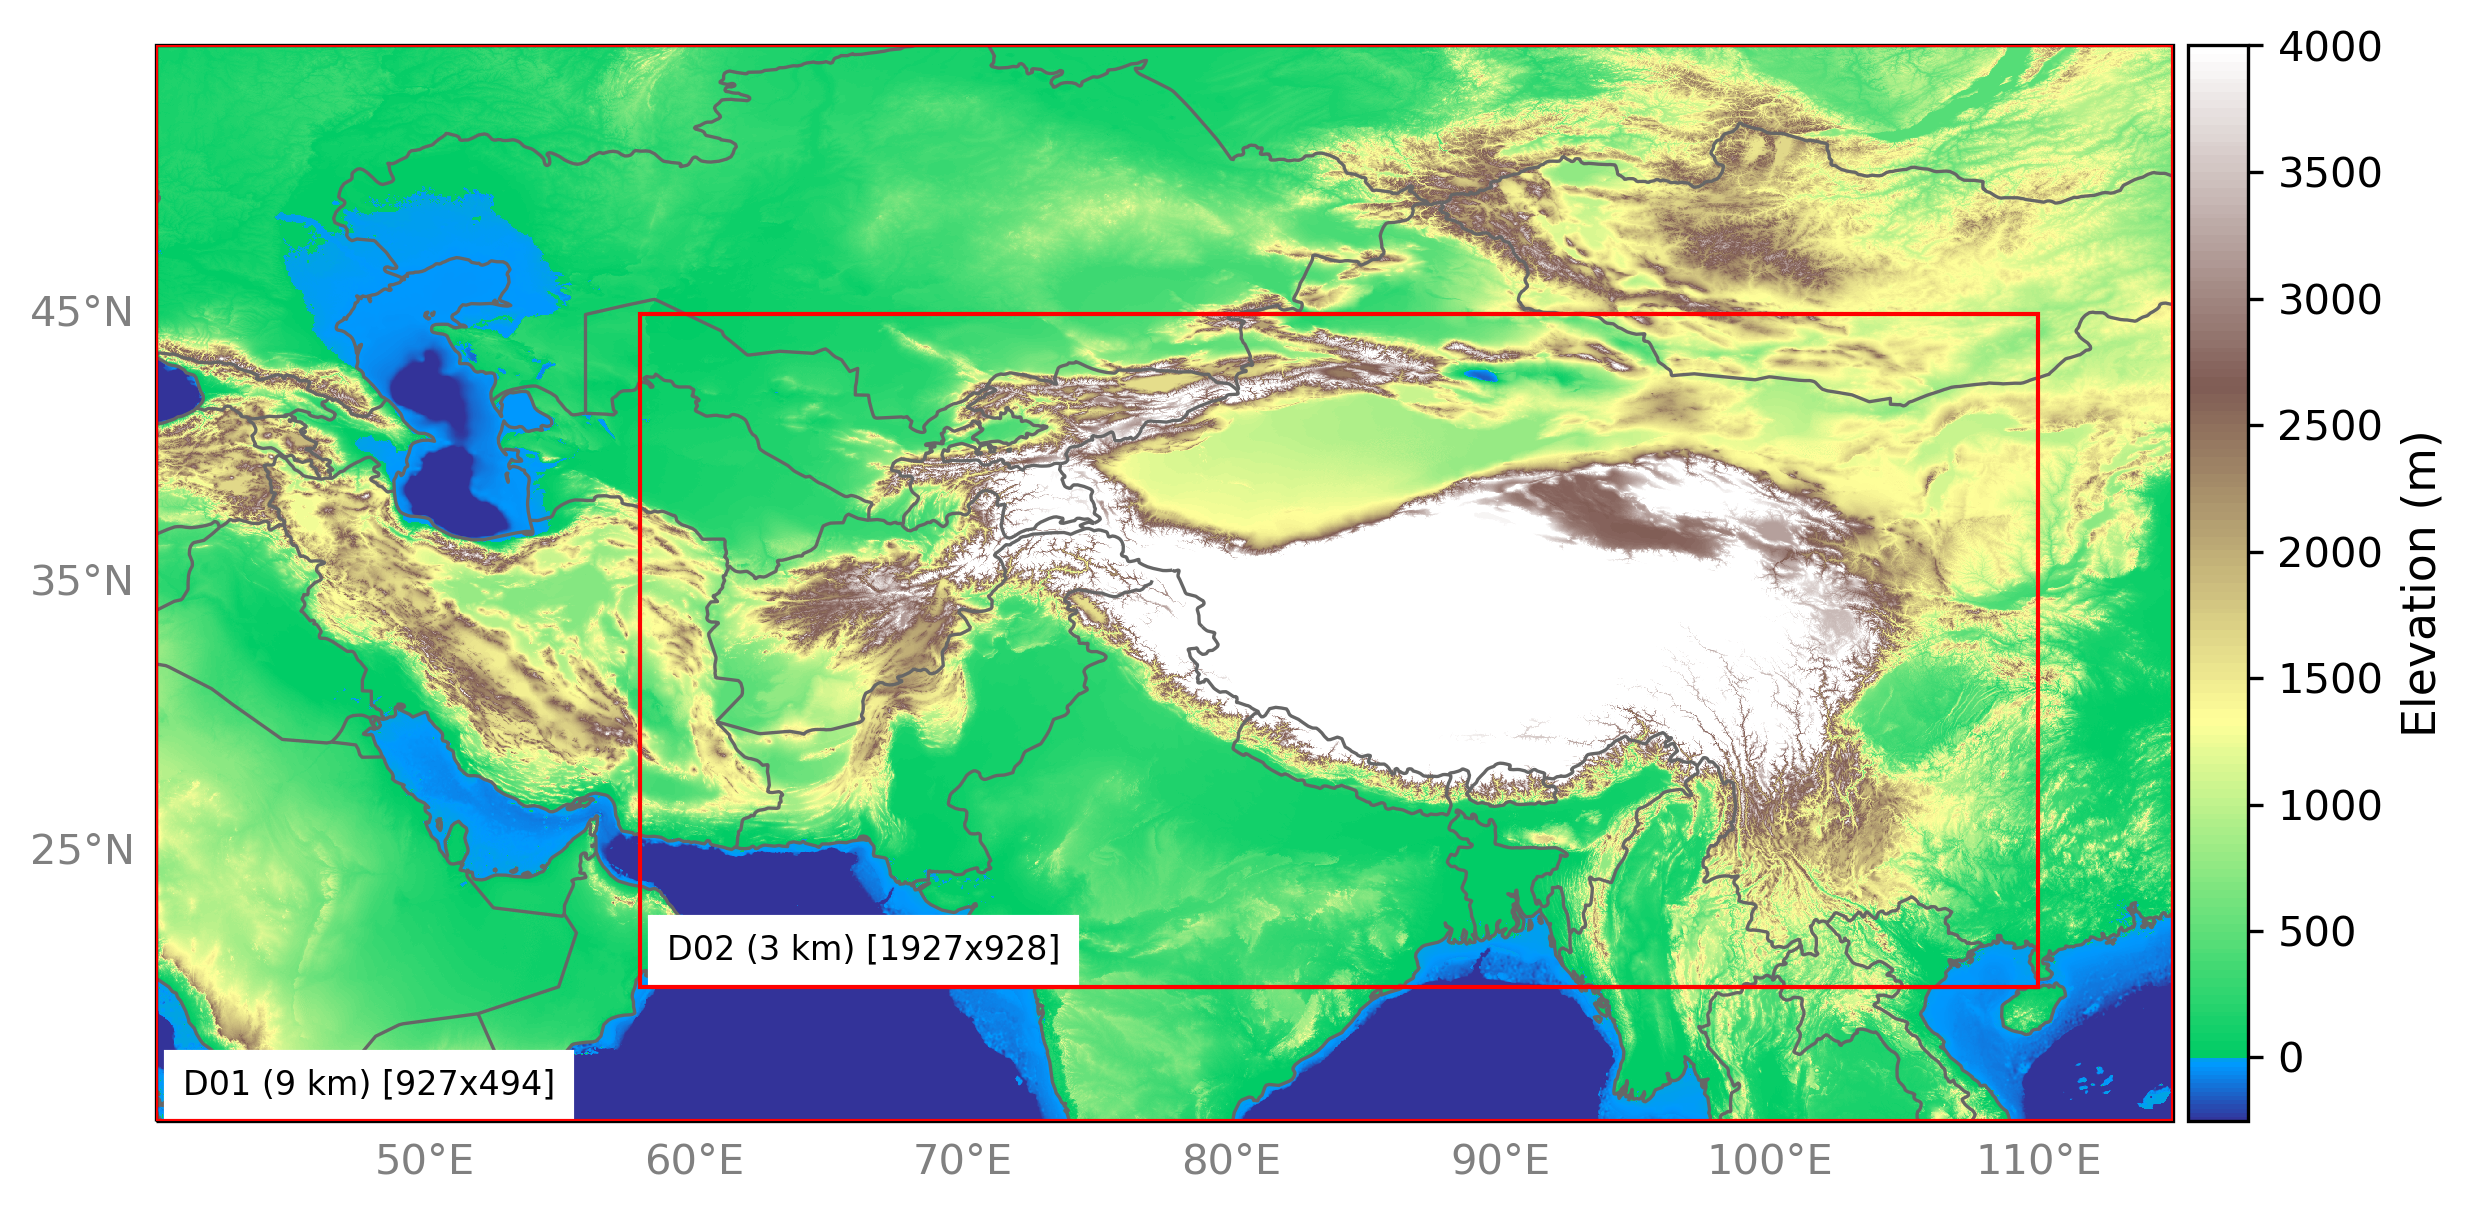

In [10]:
# Create figure
fig = plt.figure(figsize=(9, 8))
fig.dpi = 300
fname = path_to_figs + 'wrf_domain_test'
fmt = 'png'

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')

# cmap setup
cmap = cmo.topo
# clipcmap = cmocean.tools.crop_by_percent(cmap, 5, which='both', N=None)
cflevs = np.arange(-6000, 6000, )

for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=domains[0], xticks=dx, yticks=dy)

    cf = ax.pcolormesh(lons, lats, topo, rasterized=True, norm=divnorm,
                        cmap=terrain_map, shading='auto')
    
#     cf = ax.contourf(lons, lats, topo, 100, cmap=cmap, 
#                    transform=datacrs,
#                    vmin=-6000, vmax=6000,extend="both")
    
#     # Contour Lines (terrain)
#     clevs=np.array([1000])
#     cs = ax.contour(newlons, newlats, regrid_topo.bedrock, clevs, colors='red', linewidths=1.0,
#                     linestyles='solid', transform=datacrs)

    # add inner domain extents
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
#     # add hasia labels
#     add_hasia_labels(ax=ax, fntsize=10, txtcol='white')

    # add domain labels
    for i in range(len(dom_lbl)):
        ax.annotate(dom_lbl[i], lbl_loc[i], xycoords='data', fontsize=8.,
                    backgroundcolor='white')


# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
cb.set_label('Elevation (m)', fontsize=11)
cb.ax.tick_params(labelsize=10)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

In [ ]:
### vars for namelist.wps and namelist.input

today = date.today()
case_name = today.strftime('%Y%m%d')+'_case'

ndom = len(domains)
# date format for namelist.wps
sdate = list(itertools.repeat(start_date, ndom))
sdate = str(sdate)[1:-1]

edate = list(itertools.repeat(end_date, ndom))
edate = str(edate)[1:-1]

# for namelist.input format of date is a little different
dt_start = datetime.strptime(start_date, '%Y-%m-%d_%H:%S:00')
dt_end = datetime.strptime(end_date, '%Y-%m-%d_%H:%S:00')

start_items = []
end_items = []

date_fmt = ['%Y', '%m', '%d', '%H']
for i, dfmt in enumerate(date_fmt):
    start = dt_start.strftime(dfmt)
#     start = list(itertools.repeat(int(start), ndom))
#     start = str(start)[1:-1]
    start_items.append(start)
    
    end = dt_end.strftime(dfmt)
#     end = list(itertools.repeat(int(end), ndom))
#     end = str(end)[1:-1]
    end_items.append(end)

## id and grid info for domains
p_id = [1]
g_id = [1]
for i in range(ndom-1):
    p_id.append(i+1)
    g_id.append(i+2)
p_id = str(p_id)[1:-1]
g_id = str(g_id)[1:-1]

p_gr = str(parent_grid_ratio)[1:-1]

# i parent start (east-west)
i_parent_start = str(i_prt)[1:-1]
# j parent start (north-south)
j_parent_start = str(j_prt)[1:-1]

# e_we: number of gridpoints in east-west direction
e_we = str(e_we)[1:-1]
# e_sn: number of gridpoints in north-south direction
e_sn = str(e_sn)[1:-1]

# specify the resolution to interpolate static data
geog_data_res = list(itertools.repeat('default', ndom))
geog_data_res = str(geog_data_res)[1:-1]

# the resolution in meters (e.g. 27000 m = 27 km)
dx = str(resolutions[0]*1000)
dy = str(resolutions[0]*1000)

# time_step should be no more than child domain dx*6
time_step = resolutions[1]*6

# the type of map projection
map_proj = 'mercator'

# the center lat/lon of the parent domain
ref_lat   =  str(ref_lat)
ref_lon   =  str(ref_lon)

In [ ]:
## write namelist.wps
text_lst = ["&share" , \
" wrf_core = 'ARW'," ,\
" max_dom  = {0},".format(ndom) ,\
" start_date = {0},".format(sdate) ,\
" end_date   = {0},".format(edate) ,\
" interval_seconds = {0},".format(timestep*3600) ,\
" io_form_geogrid = 2," ,\
"/" ,\
"" ,\
"&geogrid" ,\
" parent_id         =   {0},".format(p_id) ,\
" parent_grid_ratio =   {0},".format(p_gr) ,\
" i_parent_start    =   {0},".format(i_parent_start) ,\
" j_parent_start    =   {0},".format(j_parent_start) ,\
" e_we              = {0},".format(e_we) ,\
" e_sn              = {0},".format(e_sn) ,\
" geog_data_res     = {0},".format(geog_data_res) ,\
" dx = {0},".format(dx) ,\
" dy = {0},".format(dy) ,\
" map_proj = {0},".format(map_proj) ,\
" ref_lat   =  {0},".format(ref_lat) ,\
" ref_lon   =  {0},".format(ref_lon) ,\
" truelat1  =  30.0," ,\

" geog_data_path = '/u/eot/dlnash/scratch/WRF_WPS_build_4.3/WPS_GEOG'" ,\
"/" ,\
"" ,\
"&ungrib" ,\
" out_format = 'WPS'," ,\
" prefix = '/u/eot/dlnash/scratch/data/wrf/{0}/IntermediateData/ungrib/ERA5_sfc',".format(case_name) ,\
"/" ,\
"" ,\
"&metgrid" ,\
" fg_name = '/u/eot/dlnash/scratch/data/wrf/{0}/IntermediateData/ungrib/ERA5_prs','/u/eot/dlnash/scratch/data/wrf/{0}/IntermediateData/ungrib/ERA5_sfc',".format(case_name) ,\
" opt_output_from_metgrid_path = '/u/eot/dlnash/scratch/data/wrf/{0}/IntermediateData/metgrid/',".format(case_name) ,\
" io_form_metgrid = 2, " ,\
"/" ]

In [ ]:
filename = "../out/namelist.wps"

#w tells python we are opening the file to write into it
outfile = open(filename, 'w')

for i, tlst in enumerate(text_lst):
    outfile.write(tlst + '\n')

outfile.close() #Close the file when we’re done!

In [ ]:
text_lst = ["&time_control" ,\
" run_days                            = 0," ,\
" run_hours                           = 0," ,\
" run_minutes                         = 0," ,\
" run_seconds                         = 0," ,\
" start_year                          = {0}, {0},".format(start_items[0]) ,\
" start_month                         = {0}, {0},".format(start_items[1]) ,\
" start_day                           = {0}, {0},".format(start_items[2]) ,\
" start_hour                          = {0}, {0},".format(start_items[3]) ,\
" start_minute                        = 00,    00," ,\
" start_second                        = 00,    00," ,\
" end_year                            = {0}, {0},".format(end_items[0]) ,\
" end_month                           = {0}, {0},".format(end_items[1]) ,\
" end_day                             = {0}, {0},".format(end_items[2]) ,\
" end_hour                            = {0}, {0},".format(end_items[3]) ,\
" end_minute                          = 00,    00," ,\
" end_second                          = 00,    00," ,\
" interval_seconds                    = {0},".format(timestep*3600) ,\
" input_from_file                     = .true., .true.," ,\
" history_interval                    = 180,    60," ,\
" frames_per_outfile                  = 99999, 99999," ,\
" auxinput1_inname = '/u/eot/dlnash/scratch/data/wrf/{0}/IntermediateData/metgrid/met_em.d<domain>.<date>',".format(case_name) ,\
" history_outname='/u/eot/dlnash/scratch/data/wrf/{0}/AnalysisData/wrfout_d<domain>.<date>',".format(case_name) ,\
" adjust_output_times                 = .true.," ,\
" restart                             = .false.," ,\
" restart_interval                    =  720," ,\
" write_hist_at_0h_rst                = .true.," ,\
" auxinput4_inname                    = 'wrflowinp_d<domain>'" ,\
" auxinput4_interval                  = 60,  60," ,\
" io_form_auxhist23                   = 2," ,\
" io_form_auxinput4                   = 2," ,\
" all_ic_times                        = .false.," ,\
" io_form_history                     = 2," ,\
" io_form_restart                     = 2," ,\
" io_form_input                       = 2," ,\
" io_form_boundary                    = 2," ,\
" debug_level                         = 0," ,\
"/" ,\
"" ,\
"&domains",\
" time_step                           = {0},".format(time_step) ,\
" time_step_fract_num                 = 0," ,\
" time_step_fract_den                 = 1," ,\
" max_dom                             = {0},".format(ndom) ,\
" e_we                                = {0},".format(e_we) ,\
" e_sn                                = {0},".format(e_sn) ,\
" e_vert                              =  55,    55," ,\
" p_top_requested                     = 5000," ,\
" num_metgrid_levels                  = 38," ,\
" num_metgrid_soil_levels             = 4," ,\
" interp_type                         = 2," ,\
" extrap_type                         = 2," ,\
" t_extrap_type                       = 2," ,\
" lowest_lev_from_sfc                 = .false." ,\
" use_levels_below_ground             = .true." ,\
" use_surface                         = .true." ,\
" lagrange_order                      = 1," ,\
" force_sfc_in_vinterp                = 1," ,\
" zap_close_levels                    = 500," ,\
" dx                                  = {0},".format(dx) ,\
" dy                                  = {0},".format(dy) ,\
" grid_id                             = {0}".format(g_id) ,\
" parent_id                           = {0}".format(p_id) ,\
" i_parent_start                      = {0},".format(i_parent_start) ,\
" j_parent_start                      = {0},".format(j_parent_start) ,\
" parent_grid_ratio                   = {0},".format(p_gr) ,\
" parent_time_step_ratio              = {0},".format(p_gr) ,\
" feedback                            = 1," ,\
" smooth_option                       = 0," ,\
"! nproc_x                             =  40," ,\
"! nproc_y                             =  36," ,\
"/" ,\
"",\
"&physics" ,\
" mp_physics                          = 8,     8," ,\
" ra_lw_physics                       = 4,     4," ,\
" ra_sw_physics                       = 4,     4," ,\
" radt                                = 20,    20," ,\
" sf_sfclay_physics                   = 1,     1," ,\
" sf_surface_physics                  = 4,     4," ,\
" bl_pbl_physics                      = 1,     1," ,\
" bldt                                = 0,     0," ,\
" cu_physics                          = 1,     0," ,\
" kfeta_trigger                       = 1," ,\
" cudt                                = 5,     5," ,\
" ishallow                            = 0," ,\
" shcu_physics                        = 0,     0," ,\
" isfflx                              = 1," ,\
" ifsnow                              = 1," ,\
" icloud                              = 1," ,\
" cu_rad_feedback                     = .true., .true.," ,\
" cu_diag                             = 0," ,\
" topo_wind                           = 0,   0," ,\
" sf_surface_mosaic                   = 0," ,\
" mosaic_cat                          = 3," ,\
" slope_rad                           = 0,   0," ,\
" topo_shading                        = 0,   0," ,\
" shadlen                             = 25000.," ,\
" surface_input_source                = 1," ,\
" num_soil_layers                     = 4," ,\
" sst_update                          = 1," ,\
" usemonalb                           = .true.," ,\
" tmn_update                          = 1," ,\
" lagday                              = 150," ,\
" sst_skin                            = 1," ,\
" sf_urban_physics                    = 0,     0," ,\
" cam_abs_freq_s                      = 21600," ,\
" levsiz                              = 59," ,\
" paerlev                             = 29," ,\
" do_radar_ref    = 1," ,\
"/" ,\
"" ,\
"&noah_mp" ,\
" dveg     = 4," ,\
" opt_crs  = 1," ,\
" opt_btr  = 1," ,\
" opt_run  = 1," ,\
" opt_sfc  = 1," ,\
" opt_frz  = 1," ,\
" opt_inf  = 1," ,\
" opt_rad  = 3," ,\
" opt_alb  = 2," ,\
" opt_snf  = 1," ,\
" opt_tbot = 2," ,\
" opt_stc  = 1," ,\
"/" ,\
"" ,\
"&fdda",\
" grid_fdda                           = 0,     0," ,\
" gfdda_inname                        = 'wrffdda_d<domain>'," ,\
" gfdda_end_h                         = 99999999, 4320," ,\
" gfdda_interval_m                    = 360,   360," ,\
" fgdt                                = 0,     0," ,\
" fgdtzero                            = 0,     0," ,\
" if_no_pbl_nudging_uv                = 0,     1," ,\
" if_no_pbl_nudging_t                 = 0,     1," ,\
" if_no_pbl_nudging_q                 = 0,     1," ,\
" if_zfac_uv                          = 0,     0," ,\
"  k_zfac_uv                          = 0,     0," ,\
" if_zfac_t                           = 0,     0," ,\
"  k_zfac_t                           = 0,     0," ,\
" if_zfac_q                           = 0,     0," ,\
"  k_zfac_q                           = 0,     0," ,\
" guv                                 = 0.0003,  0.0003," ,\
" gt                                  = 0.0003,  0.0003," ,\
" gq                                  = 0.0003,  0.0003," ,\
" if_ramping                          = 1," ,\
" dtramp_min                          = 60.0," ,\
" io_form_gfdda                       = 2," ,\
"/" ,\
"" ,\
"&dynamics",\
" w_damping                           = 1," ,\
" diff_opt                            = 2," ,\
" km_opt                              = 4," ,\
" hybrid_opt                          = 0," ,\
" etac                                = 0.2," ,\
" diff_6th_opt                        = 0,         0," ,\
" diff_6th_factor                     = 0.12,   0.12," ,\
" base_temp                           = 290." ,\
" damp_opt                            = 0," ,\
" zdamp                               = 5000.,  5000.," ,\
" dampcoef                            = 0.2,    0.2," ,\
" khdif                               = 0,      0," ,\
" kvdif                               = 0,      0," ,\
" non_hydrostatic                     = .true., .true.," ,\
" moist_adv_opt                       = 1,      1," ,\
" scalar_adv_opt                      = 1,      1," ,\
"/" ,\
"" ,\
"&bdy_control" ,\
" spec_bdy_width                      = 5," ,\
" spec_zone                           = 1," ,\
" relax_zone                          = 4," ,\
" specified                           = .true., .false.," ,\
" nested                              = .false., .true.," ,\
"/" ,\
"" ,\
"&grib2" ,\
"/" ,\
"" ,\
"&namelist_quilt" ,\
" nio_tasks_per_group = 0," ,\
" nio_groups = 1," ,\
"/"]


In [ ]:
filename = "../out/namelist.input"

#w tells python we are opening the file to write into it
outfile = open(filename, 'w')

for i, tlst in enumerate(text_lst):
    outfile.write(tlst + '\n')

outfile.close() #Close the file when we’re done!